### IMPORTS AND HELPERS

In [1]:
import pandas as pd
import os
import hashlib
from tqdm import tqdm
from scipy.special import expit 
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.special import expit
import numpy as np
import seaborn as sns




# --- Mod decoding and helpers ---
MODS = {
    1: "NF", 2: "EZ", 4: "TD", 8: "HD", 16: "HR", 32: "SD", 64: "DT",
    128: "RX", 256: "HT", 512: "NC", 1024: "FL", 2048: "AU", 4096: "SO",
    8192: "AP", 16384: "PF", 32768: "K4", 65536: "K5", 131072: "K6",
    262144: "K7", 524288: "K8", 1048576: "FI", 2097152: "RN"
}
preference_mods = ["PF", "SD", "HD", "NC"]
banned_mods = ["NF", "EZ", "TD", "RX", "HT", "FL", "AU", "SO", "AP", "FI", "RN", "K4", "K5", "K6", "K7", "K8"]


def decode_mods(mods_int: int):
    return [acronym for bit, acronym in MODS.items() if mods_int & bit]

def generate_mod_beatmap_id(beatmap_id, mods_string):
    return int(hashlib.sha256(f"{mods_string}_{beatmap_id}".encode()).hexdigest(), 16) % (10 ** 12)

genre_map = {0: "Any", 1: "Unspecified", 2: "Video Game", 3: "Anime", 4: "Rock", 5: "Pop", 6: "Other",
             7: "Novelty", 9: "Hip Hop", 10: "Electronic", 11: "Metal", 12: "Classical", 13: "Folk", 14: "Jazz"}
language_map = {0: "Any", 1: "Other", 2: "English", 3: "Japanese", 4: "Chinese", 5: "Instrumental", 6: "Korean",
                7: "French", 8: "German", 9: "Swedish", 10: "Spanish", 11: "Italian", 12: "Russian", 13: "Polish", 14: "Other"}


### BEATMAPS CORE + FAVOURITE_FACTOR

In [4]:
# --- Load and prepare beatmaps ---
beatmap_input = "export/2025_05_01_performance_osu_random_10000__beatmaps.csv"
beatmap_output = "processed/beatmaps.csv"

# Mapping tables
genre_map = {0: "Any", 1: "Unspecified", 2: "Video Game", 3: "Anime", 4: "Rock", 5: "Pop", 6: "Other",
             7: "Novelty", 9: "Hip Hop", 10: "Electronic", 11: "Metal", 12: "Classical", 13: "Folk", 14: "Jazz"}
language_map = {0: "Any", 1: "Other", 2: "English", 3: "Japanese", 4: "Chinese", 5: "Instrumental", 6: "Korean",
                7: "French", 8: "German", 9: "Swedish", 10: "Spanish", 11: "Italian", 12: "Russian", 13: "Polish", 14: "Other"}
preference_mods = ["PF", "SD", "HD", "NC"]

# Decode mods
MODS = {
    1: "NF", 2: "EZ", 4: "TD", 8: "HD", 16: "HR", 32: "SD", 64: "DT", 128: "RX", 256: "HT", 512: "NC",
    1024: "FL", 2048: "AU", 4096: "SO", 8192: "AP", 16384: "PF", 32768: "K4", 65536: "K5", 131072: "K6",
    262144: "K7", 524288: "K8", 1048576: "FI", 2097152: "RN"
}
def decode_mods(mods_int: int):
    return [acronym for bit, acronym in MODS.items() if mods_int & bit]

def generate_mod_beatmap_id(beatmap_id, mods_string):
    return int(hashlib.sha256(f"{mods_string}_{beatmap_id}".encode()).hexdigest(), 16) % (10 ** 12)

# Load and process
print("📥 Loading and preparing beatmaps...")
beatmaps_df = pd.read_csv(beatmap_input)
beatmaps_df["genre"] = beatmaps_df["genre_id"].map(genre_map).fillna("Unknown")
beatmaps_df["language"] = beatmaps_df["language_id"].map(language_map).fillna("Unknown")
beatmaps_df.drop(columns=["genre_id", "language_id"], inplace=True)

# Compute mod string
beatmaps_df['mods_list'] = beatmaps_df['mods'].apply(decode_mods)
beatmaps_df['mods_string'] = beatmaps_df['mods_list'].apply(
    lambda x: ''.join(sorted(mod for mod in x if mod not in preference_mods)) or 'NM'
)
beatmaps_df.drop(columns=["mods", "mods_list"], inplace=True)

# Compute mod_beatmap_id
tqdm.pandas(desc="🔐 Hashing beatmap+mods")
beatmaps_df['mod_beatmap_id'] = beatmaps_df.progress_apply(
    lambda row: generate_mod_beatmap_id(row['beatmap_id'], row['mods_string']), axis=1
)

# Reorder columns
cols = ['mod_beatmap_id', 'beatmap_id', 'mods_string'] + [c for c in beatmaps_df.columns if c not in {'mod_beatmap_id', 'beatmap_id', 'mods_string'}]
beatmaps_df = beatmaps_df[cols]

# --- Add favourite factor for all mod variants using NM-based set statistics ---
print("🧮 Computing favourite_factor from NM beatmaps, applying to all variants...")

# Step 1: Compute total set playcount using NM beatmaps
nm_only = beatmaps_df[beatmaps_df["mods_string"] == "NM"].copy()
set_playcounts = nm_only.groupby("beatmapset_id")["playcount"].sum().reset_index(name="total_set_playcount")

# Step 2: Merge in set playcount to all beatmaps (not just NM)
beatmaps_df = beatmaps_df.merge(set_playcounts, on="beatmapset_id", how="left")

# Step 3: Compute favourite factor: set_favourite_count / total_set_playcount
beatmaps_df["favourite_factor"] = beatmaps_df["set_favourite_count"] / beatmaps_df["total_set_playcount"]

# Step 4: Normalize favourite factor (robustly, clipped to 1st–99th percentile)
valid = beatmaps_df["favourite_factor"].dropna()
q01, q99 = valid.quantile([0.01, 0.99])
clipped = beatmaps_df["favourite_factor"].clip(lower=q01, upper=q99)
min_v, max_v = clipped.min(), clipped.max()
if pd.notnull(min_v) and pd.notnull(max_v) and min_v != max_v:
    beatmaps_df["favourite_factor"] = (clipped - min_v) / (max_v - min_v)
else:
    beatmaps_df["favourite_factor"] = 0.0


# Save finalized beatmaps
os.makedirs(os.path.dirname(beatmap_output), exist_ok=True)
beatmaps_df.to_csv(beatmap_output, index=False)
print("✅ Saved beatmaps with favourite_factor →", beatmap_output)


📥 Loading and preparing beatmaps...


🔐 Hashing beatmap+mods:   8%|▊         | 43088/524496 [00:00<00:06, 74271.53it/s]


KeyboardInterrupt: 

### SCORES FULL CORE

In [3]:
# --- Setup ---
raw_dir = "export"
proc_dir = "processed"
os.makedirs(proc_dir, exist_ok=True)
schemas = ["random", "top"]

# --- Load preprocessed beatmaps for ID merging ---
beatmaps_df = pd.read_csv(os.path.join(proc_dir, "beatmaps.csv"))
mod_map = beatmaps_df[["beatmap_id", "mods_string", "mod_beatmap_id"]].copy()

# --- Process each tag ---
for tag in schemas:
    print(f"\n🔄 Processing {tag} scores...")

    # Load and decode mods
    in_path = os.path.join(raw_dir, f"2025_05_01_performance_osu_{tag}_10000__scores_high.csv")
    out_path = os.path.join(proc_dir, f"{tag}_10000__scores.csv")
    scores_df = pd.read_csv(in_path)

    tqdm.pandas(desc="Mod decode")
    scores_df["mods_list"] = scores_df["enabled_mods"].progress_apply(decode_mods)
    
    # Remove scores with banned mods
    scores_df = scores_df[~scores_df["mods_list"].apply(lambda x: any(mod in x for mod in banned_mods))]

    # Generate mods_string
    scores_df["mods_string"] = scores_df["mods_list"].apply(
        lambda mods: ''.join(sorted(mod for mod in mods if mod not in preference_mods)) or "NM"
    )

    # Deduplicate per user, beatmap, mods
    scores_df = scores_df.sort_values("pp", ascending=False)
    scores_df = scores_df.drop_duplicates(["beatmap_id", "user_id", "mods_string"], keep="first")

    # Merge to get mod_beatmap_id
    scores_df = scores_df.merge(mod_map, on=["beatmap_id", "mods_string"], how="left")
    scores_df.dropna(subset=["mod_beatmap_id"], inplace=True)

    # Finalize and export
    scores_df = scores_df.reset_index(drop=True)
    scores_df["score_id"] = scores_df.index + 1

    # Column order
    col_order = ["score_id", "mod_beatmap_id", "beatmap_id", "mods_string"] + \
                [c for c in scores_df.columns if c not in {"score_id", "mod_beatmap_id", "beatmap_id", "mods_string"}]
    scores_df = scores_df[col_order]

    scores_df.to_csv(out_path, index=False)
    print(f"✅ Saved cleaned scores to: {out_path}")


🔄 Processing random scores...


Mod decode: 100%|██████████| 4018988/4018988 [00:06<00:00, 605203.34it/s]


✅ Saved cleaned scores to: processed\random_10000__scores.csv

🔄 Processing top scores...


Mod decode: 100%|██████████| 51248991/51248991 [01:36<00:00, 532175.12it/s]


✅ Saved cleaned scores to: processed\top_10000__scores.csv


### USERS CORE + SKILL STABILZATION

In [4]:
# --- Config ---
export_dir = "export"
proc_dir = "processed"
top_n_total = 20
top_n_required = 10
schemas = ["random", "top"]

# --- Setup containers ---
all_scores = []
all_scores_dated = []

# --- Load and prepare scores ---
for tag in schemas:
    print(f"\n📊 Processing {tag} user scores...")

    scores_path = f"{proc_dir}/{tag}_10000__scores.csv"
    scores_df = pd.read_csv(scores_path)

    scores_df = scores_df[scores_df['pp'].notna() & (scores_df['pp'] > 0)].copy()
    scores_df['date'] = pd.to_datetime(scores_df['date'])

    scores_df = scores_df.sort_values(['user_id', 'pp'], ascending=[True, False])
    scores_df['rank'] = scores_df.groupby('user_id').cumcount()
    scores_df = scores_df[scores_df['rank'] < 100]
    scores_df['weight'] = 0.95 ** scores_df['rank']
    scores_df['weighted_pp'] = scores_df['pp'] * scores_df['weight']

    all_scores.append(scores_df[['user_id', 'weighted_pp']])
    all_scores_dated.append(scores_df[['user_id', 'pp', 'date']])

# --- Combine all scores for total weighted pp ---
combined = pd.concat(all_scores)
user_total_pp = (
    combined.groupby('user_id')['weighted_pp'].sum()
    .reset_index()
    .rename(columns={'weighted_pp': 'total_weighted_pp'})
)

# --- Compute skill stabilization date ---
print("\n📅 Estimating skill stabilization date...")
dated = pd.concat(all_scores_dated)
stabilization_dates = {}

for user_id, group in tqdm(dated.groupby('user_id'), total=dated['user_id'].nunique(), desc="Users"):
    top_scores = group.sort_values('pp', ascending=False).head(top_n_total)
    if len(top_scores) >= top_n_required:
        cutoff_score = top_scores.iloc[top_n_required - 1]
        stabilization_dates[user_id] = cutoff_score['date']

stabilization_df = (
    pd.DataFrame.from_dict(stabilization_dates, orient='index', columns=['skill_stabilization_date'])
    .reset_index()
    .rename(columns={'index': 'user_id'})
)

# --- Load users from export/, add fields, and save to processed/ ---
for tag in schemas:
    print(f"\n📝 Creating processed users table for: {tag}")
    user_in = f"{export_dir}/2025_05_01_performance_osu_{tag}_10000__users.csv"
    user_out = f"{proc_dir}/{tag}_10000__users.csv"

    users_df = pd.read_csv(user_in)
    users_df = users_df.merge(user_total_pp, on='user_id', how='left')
    users_df = users_df.merge(stabilization_df, on='user_id', how='left')

    users_df.to_csv(user_out, index=False)
    print(f"✅ Saved: {user_out}")


📊 Processing random user scores...

📊 Processing top user scores...

📅 Estimating skill stabilization date...


Users: 100%|██████████| 19164/19164 [00:03<00:00, 5006.07it/s]



📝 Creating processed users table for: random
✅ Saved: processed/random_10000__users.csv

📝 Creating processed users table for: top
✅ Saved: processed/top_10000__users.csv


### ITEM RELEVANCY FILTER + COLUMNS

In [5]:
# --- Config --- 
relevancy_threshold = 10      # minimum number of scores required for relevance
filter_irrelevant = True      # set to False to keep all rows but still add flags

# --- Load beatmaps ---
proc_dir = "processed"
beatmap_path = f"{proc_dir}/beatmaps.csv"
beatmaps_df = pd.read_csv(beatmap_path)

# --- Compute relevancy from scores ---
print("🔎 Determining relevant beatmaps per user set...")

relevancy_cols = {}
relevant_counts = {}
relevant_ids_by_tag = {}

for tag in ['random', 'top']:
    print(f"📂 Checking scores in {tag} set...")
    score_path = f"{proc_dir}/{tag}_10000__scores.csv"
    scores = pd.read_csv(score_path, usecols=['mod_beatmap_id'])

    score_counts = scores['mod_beatmap_id'].value_counts()
    relevant_ids = score_counts[score_counts >= relevancy_threshold].index
    relevant_ids_by_tag[tag] = set(relevant_ids)

    # Mark beatmaps as relevant for this tag
    relevancy_cols[f'relevant_{tag}'] = beatmaps_df['mod_beatmap_id'].isin(relevant_ids).astype(int)
    relevant_counts[tag] = len(relevant_ids)

# --- Add relevancy columns to beatmaps ---
for col, values in relevancy_cols.items():
    beatmaps_df[col] = values

# --- Print beatmap relevance summary ---
print(f"🔢 Relevant beatmaps per user group:")
for tag in ['random', 'top']:
    print(f"   • {tag.title():<6}: {relevant_counts[tag]:>5} beatmaps")

# --- Optional filtering ---
if filter_irrelevant:
    before = len(beatmaps_df)
    beatmaps_df = beatmaps_df[
        (beatmaps_df['relevant_top'] == 1) | (beatmaps_df['relevant_random'] == 1)
    ]
    after = len(beatmaps_df)
    print(f"✅ Filtered beatmaps: {before} → {after} with threshold ≥ {relevancy_threshold}")

    # --- Filter scores per tag using tag-specific relevant_ids ---
    print("🧹 Filtering score files by relevant beatmaps (per-tag)...")
    for tag in ['random', 'top']:
        score_path = f"{proc_dir}/{tag}_10000__scores.csv"
        scores_df = pd.read_csv(score_path)
        before_scores = len(scores_df)
        scores_df = scores_df[scores_df['mod_beatmap_id'].isin(relevant_ids_by_tag[tag])]
        after_scores = len(scores_df)
        scores_df.to_csv(score_path, index=False)
        print(f"   • {tag.title()} scores: {before_scores} → {after_scores} rows kept")

else:
    print(f"✅ Added relevancy flags (threshold ≥ {relevancy_threshold}), no filtering applied.")

# --- Save updated beatmaps ---
beatmaps_df.to_csv(beatmap_path, index=False)
print(f"💾 Saved beatmaps with relevancy flags: {beatmap_path}")


🔎 Determining relevant beatmaps per user set...
📂 Checking scores in random set...
📂 Checking scores in top set...
🔢 Relevant beatmaps per user group:
   • Random: 60498 beatmaps
   • Top   : 254833 beatmaps
✅ Filtered beatmaps: 524496 → 257979 with threshold ≥ 10
🧹 Filtering score files by relevant beatmaps (per-tag)...
   • Random scores: 3202821 → 2611808 rows kept
   • Top scores: 37941981 → 37305629 rows kept
💾 Saved beatmaps with relevancy flags: processed/beatmaps.csv


### FARMFACTOR FOR BEATMAPS

📈 Computing farm factor for random users...


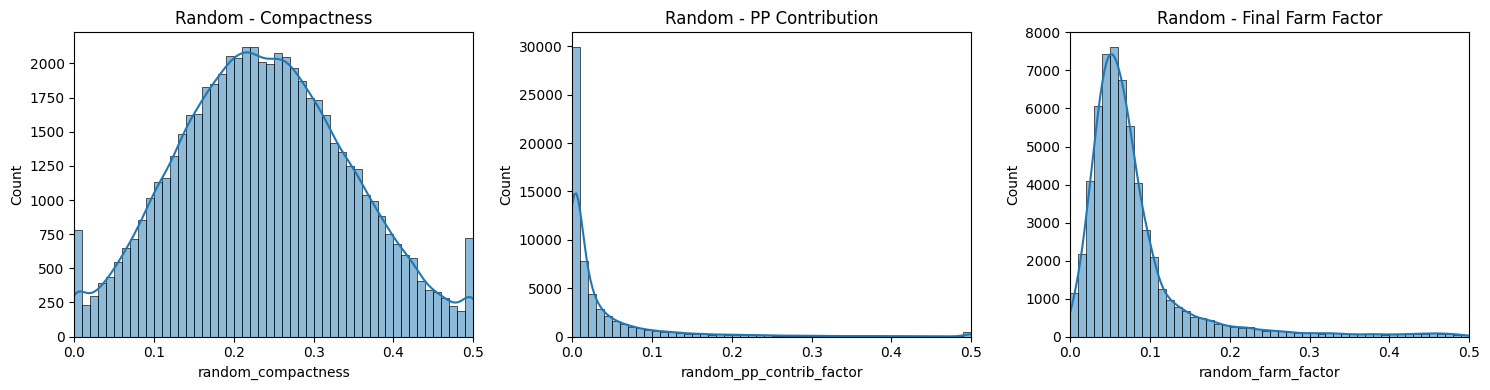

📈 Computing farm factor for top users...


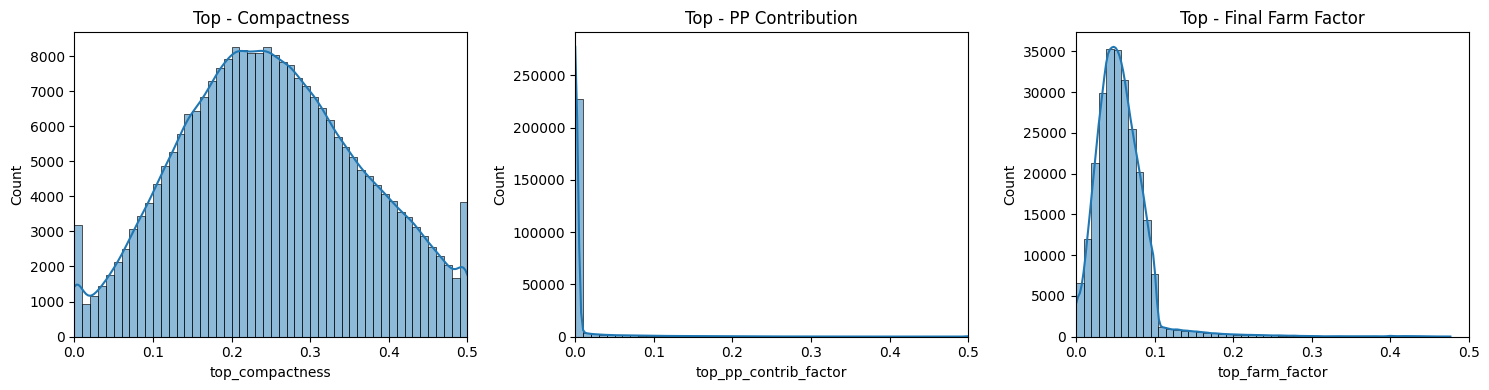

✅ Saved beatmaps with updated farm factors and full distributions.


In [6]:
# --- Config ---
proc_dir = "processed"
beatmap_path = f"{proc_dir}/beatmaps.csv"
schemas = ["random", "top"]

# --- Load beatmaps ---
beatmaps_df = pd.read_csv(beatmap_path)

# --- Helper: Normalize to [0, 0.5] using 1st–99th percentile (including zeros) ---
def normalize_to_half(series):
    clipped = series.clip(
        lower=series.quantile(0.01),
        upper=series.quantile(0.99)
    )
    return 0.5 * (clipped - clipped.min()) / (clipped.max() - clipped.min())

# --- Helper: Plot distributions (including zeros) ---
def plot_farm_distributions(farm_df, tag):
    plt.figure(figsize=(15, 4))
    for i, (col, title) in enumerate([
        (f"{tag}_compactness", "Compactness"),
        (f"{tag}_pp_contrib_factor", "PP Contribution"),
        (f"{tag}_farm_factor", "Final Farm Factor")
    ]):
        plt.subplot(1, 3, i + 1)
        sns.histplot(farm_df[col], bins=50, kde=True)
        plt.title(f"{tag.title()} - {title}")
        plt.xlim(0, 0.5)
    plt.tight_layout()
    plt.show()

# --- Compute farm factor for one user schema ---
def compute_farm_components(scores_df, tag, beatmaps_df):
    # Filter to relevant beatmaps
    relevant_col = f"relevant_{tag}"
    relevant_ids = beatmaps_df[beatmaps_df[relevant_col] == 1]['mod_beatmap_id']
    scores_df = scores_df[
        scores_df['mod_beatmap_id'].isin(relevant_ids) &
        scores_df['pp'].notna() &
        (scores_df['pp'] > 0)
    ].copy()

    # --- Compactness: avg(pp) / max(pp) ---
    compactness_df = scores_df.groupby('mod_beatmap_id').agg(
        avg_pp=('pp', 'mean'),
        max_pp=('pp', 'max')
    ).reset_index()
    compactness_df[f"{tag}_compactness"] = compactness_df['avg_pp'] / compactness_df['max_pp']
    compactness_df[f"{tag}_compactness"] = normalize_to_half(compactness_df[f"{tag}_compactness"])

    # --- PP Contribution: sum(weighted pp in top 100) / total playcount ---
    scores_df = scores_df.sort_values(['user_id', 'pp'], ascending=[True, False])
    scores_df['rank'] = scores_df.groupby('user_id').cumcount()
    scores_df = scores_df[scores_df['rank'] < 100]
    scores_df['weight'] = 0.95 ** scores_df['rank']
    scores_df['weighted_pp'] = scores_df['pp'] * scores_df['weight']

    contrib_df = scores_df.groupby('mod_beatmap_id').agg(
        total_weighted_pp=('weighted_pp', 'sum'),
        total_plays=('mod_beatmap_id', 'count')
    ).reset_index()
    contrib_df[f"{tag}_pp_contrib_factor"] = contrib_df['total_weighted_pp'] / contrib_df['total_plays']
    contrib_df[f"{tag}_pp_contrib_factor"] = normalize_to_half(contrib_df[f"{tag}_pp_contrib_factor"])

    # --- Merge components and calculate final farm factor ---
    farm_df = compactness_df.merge(contrib_df, on="mod_beatmap_id", how="outer").fillna(0.0)
    # Weighted sum: prioritize pp_contribution
    farm_df[f"{tag}_farm_factor"] = (
        0.2 * farm_df[f"{tag}_compactness"] + 0.8 * farm_df[f"{tag}_pp_contrib_factor"]
    )

    # Plotting
    plot_farm_distributions(farm_df, tag)

    return farm_df[['mod_beatmap_id', f"{tag}_farm_factor"]]

# --- Clean up existing farm factor columns (safe to re-run) ---
for tag in schemas:
    for col in [f"{tag}_farm_factor", f"{tag}_compactness", f"{tag}_pp_contrib_factor"]:
        if col in beatmaps_df.columns:
            beatmaps_df.drop(columns=[col], inplace=True)

# --- Apply for each schema ---
for tag in schemas:
    print(f"📈 Computing farm factor for {tag} users...")

    scores_df = pd.read_csv(f"{proc_dir}/{tag}_10000__scores.csv")
    farm_df = compute_farm_components(scores_df, tag, beatmaps_df)

    beatmaps_df = beatmaps_df.merge(farm_df, on="mod_beatmap_id", how="left")
    beatmaps_df[f"{tag}_farm_factor"] = beatmaps_df[f"{tag}_farm_factor"].fillna(0.0)

# --- Save updated beatmaps ---
beatmaps_df.to_csv(beatmap_path, index=False)
print("✅ Saved beatmaps with updated farm factors and full distributions.")


### ENJOYMENT FACTOR FOR SCORES

🎯 Computing enjoyment factor for all user scores...

⚙️ Processing random scores...
📥 Base scores rows: 281213
📥 Beatmaps rows: 257979
🔄 After merge with beatmaps: 281213 rows
🧹 Filtered by relevant_random: 281213 -> 281213
👀 Checking null mod_beatmap_id: 0
👀 Checking null score_id: 0
Component 1: Playcount-based enjoyment (dynamic saturation)...
🎯 Play Saturation (enabled_mods=0): 29.36
Component 2: Beatmap-level favourite popularity...
Component 3: Accuracy penalized distance from 95%...
Component 4: PP Contribution based on per-user pp ratio...
ℹ️ Favourite factor nulls: 0
ℹ️ random_farm_factor nulls: 0
✅ Component playcount_component: mean=0.470, nulls=0
✅ Component favourite_component: mean=0.038, nulls=0
✅ Component accuracy_component: mean=0.999, nulls=0
✅ Component weighted_acc: mean=0.656, nulls=0
🧠 Weighted_ppc nulls in working_df (before fillna): 0
🎉 Final enjoyment computed: mean=0.2520, nulls=0
🔁 Merged back: 281213 rows
❓ Rows with missing enjoyment after merge: 0 / 28121

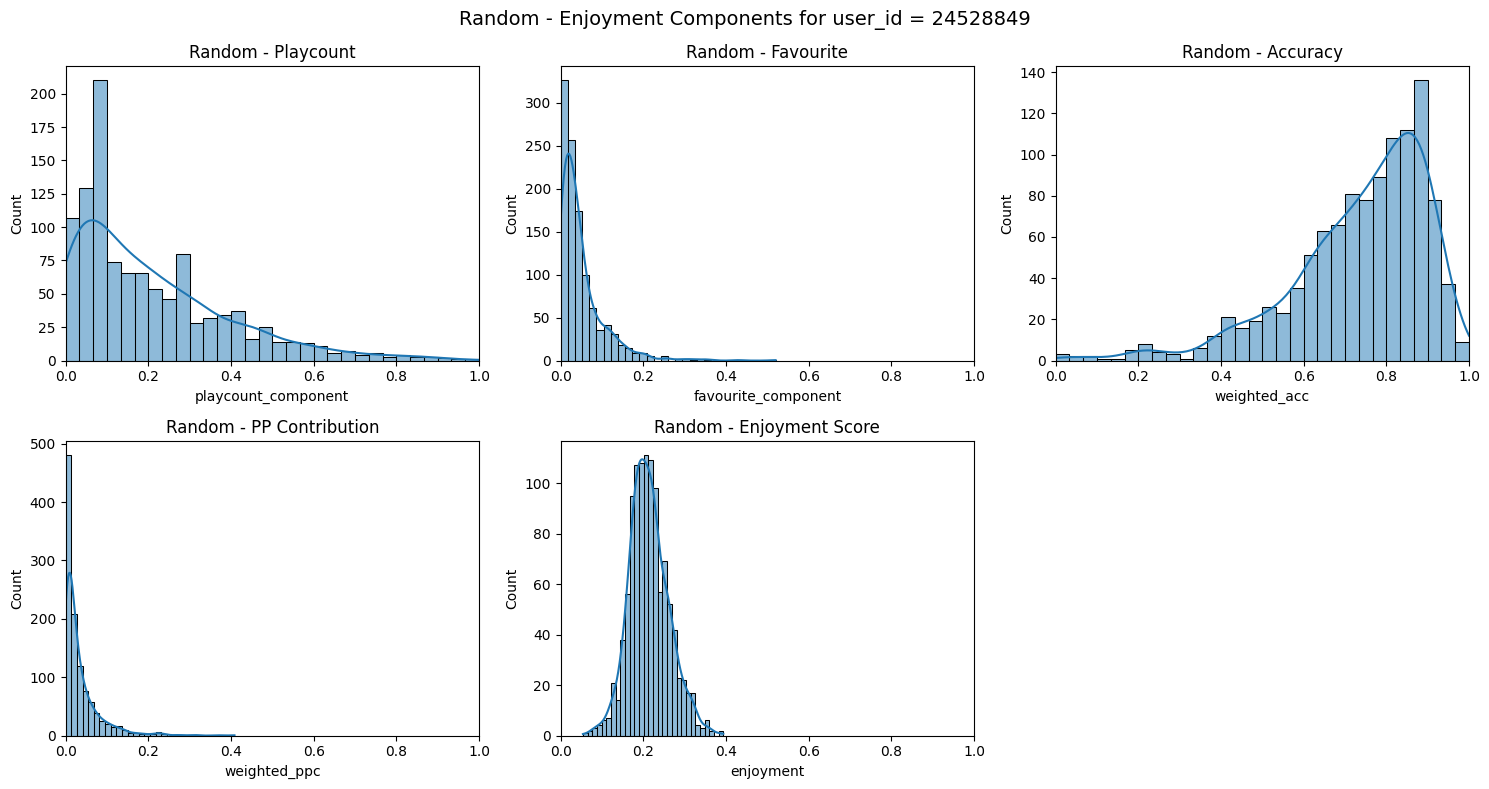

📊 Plotting global component distributions for random dataset


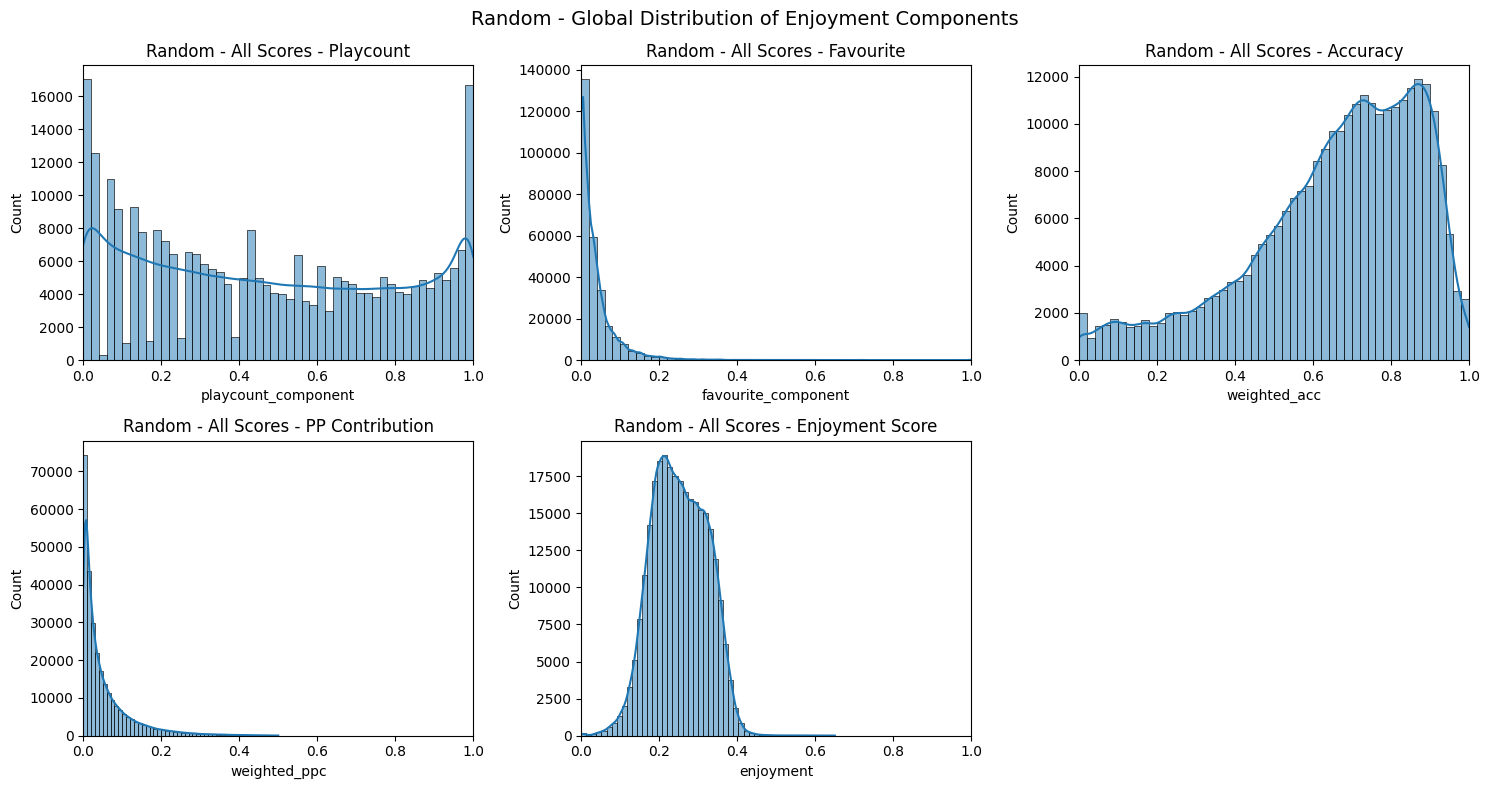


⚙️ Processing top scores...
📥 Base scores rows: 19006991
📥 Beatmaps rows: 257979
🔄 After merge with beatmaps: 19006991 rows
🧹 Filtered by relevant_top: 19006991 -> 19006991
👀 Checking null mod_beatmap_id: 0
👀 Checking null score_id: 0
Component 1: Playcount-based enjoyment (dynamic saturation)...
🎯 Play Saturation (enabled_mods=0): 34.20
Component 2: Beatmap-level favourite popularity...
Component 3: Accuracy penalized distance from 95%...
Component 4: PP Contribution based on per-user pp ratio...
ℹ️ Favourite factor nulls: 0
ℹ️ top_farm_factor nulls: 0
✅ Component playcount_component: mean=0.437, nulls=0
✅ Component favourite_component: mean=0.063, nulls=0
✅ Component accuracy_component: mean=0.999, nulls=0
✅ Component weighted_acc: mean=0.803, nulls=0
🧠 Weighted_ppc nulls in working_df (before fillna): 0
🎉 Final enjoyment computed: mean=0.2743, nulls=0
🔁 Merged back: 19006991 rows
❓ Rows with missing enjoyment after merge: 0 / 19006991
✅ Saved updated scores with enjoyment: processe

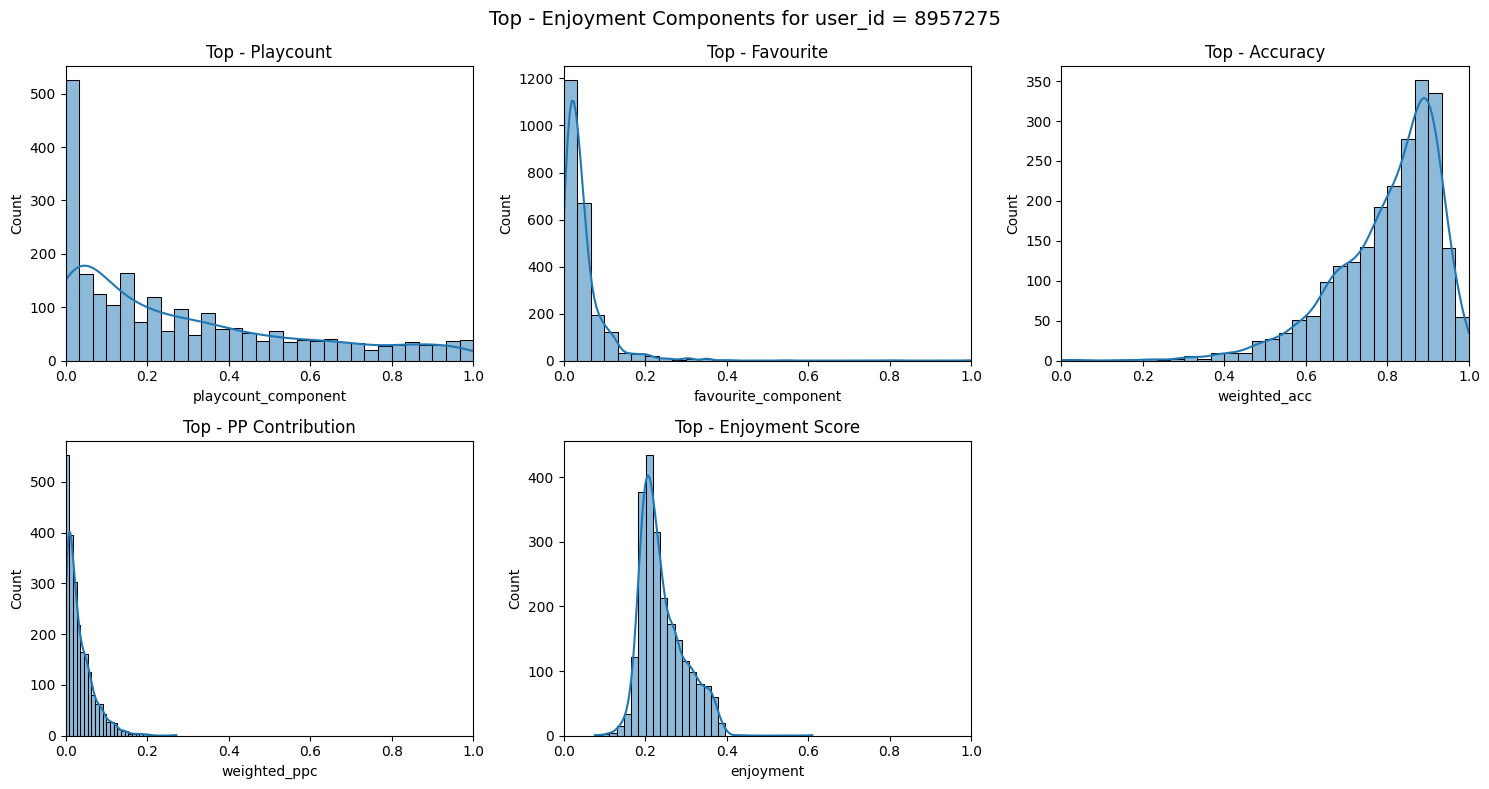

📊 Plotting global component distributions for top dataset


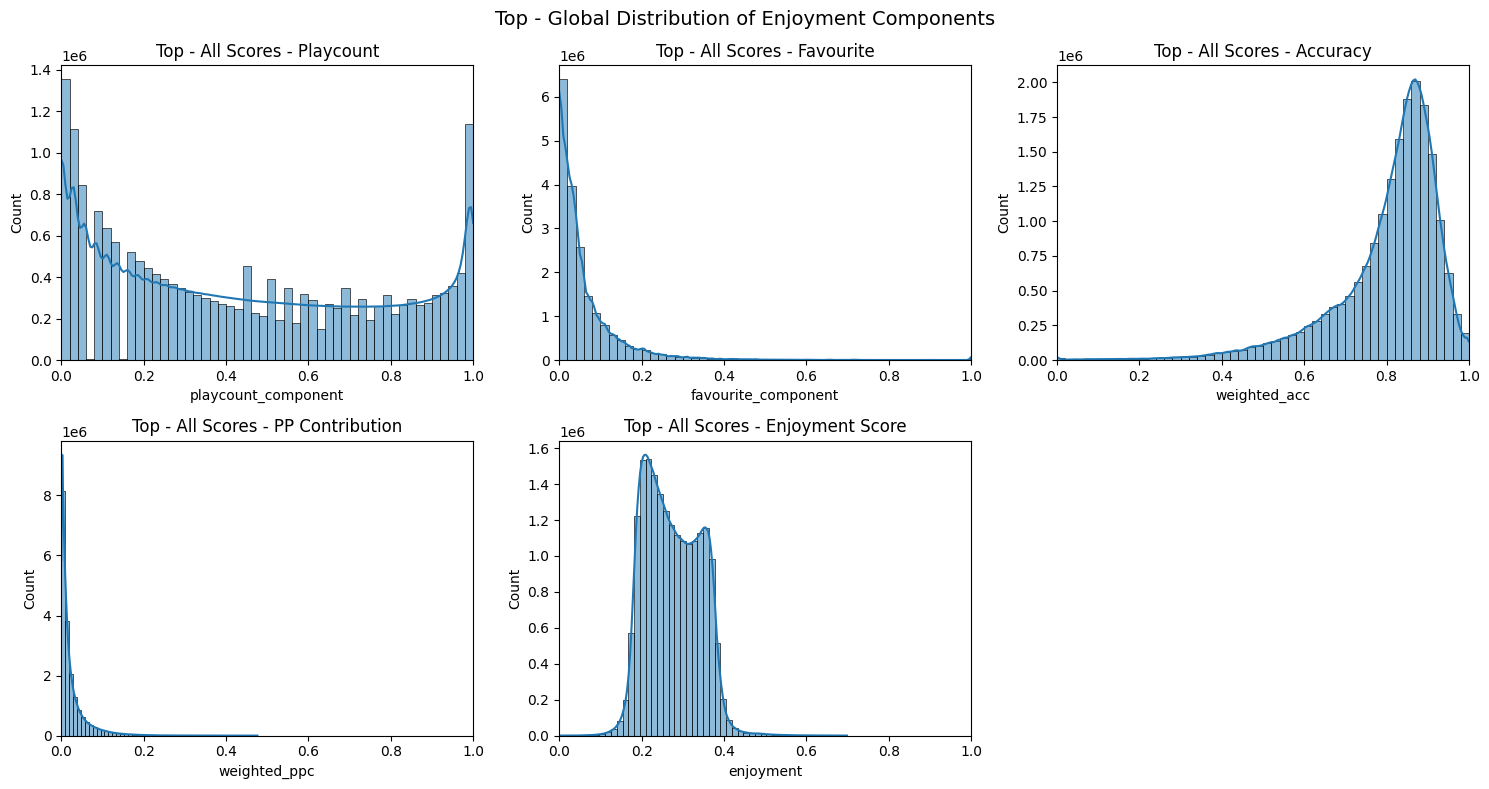

In [3]:
# --- Configuration ---
w_playcount = 0.2
w_favourite = 0.3
w_accuracy = 0.2
w_pp_contrib = 0.3
default_play_saturation = 20

components = [
    ("playcount_component", "Playcount"),
    ("favourite_component", "Favourite"),
    ("weighted_acc", "Accuracy"),
    ("weighted_ppc", "PP Contribution"),
]

print("\U0001F3AF Computing enjoyment factor for all user scores...")

for tag in ['random', 'top']:
    print(f"\n⚙️ Processing {tag} scores...")

    # --- Load data ---
    base_scores_df = pd.read_csv(f"processed/{tag}_10000__scores.csv")
    beatmaps_df = pd.read_csv("processed/beatmaps.csv")
    users_df = pd.read_csv(f"processed/{tag}_10000__users.csv")

    print(f"📥 Base scores rows: {len(base_scores_df)}")
    print(f"📥 Beatmaps rows: {len(beatmaps_df)}")

    # --- Initial Cleanup ---
    base_scores_df = base_scores_df.drop(columns=['enjoyment'], errors='ignore')
    working_df = base_scores_df.copy()

    # --- Merge beatmap data ---
    merge_cols = ['mod_beatmap_id', 'favourite_factor', f"{tag}_farm_factor"]
    if f"relevant_{tag}" in beatmaps_df.columns:
        merge_cols.append(f"relevant_{tag}")
    else:
        print(f"⚠️ Column relevant_{tag} missing in beatmaps!")

    working_df = working_df.merge(beatmaps_df[merge_cols], on='mod_beatmap_id', how='left')
    print(f"🔄 After merge with beatmaps: {len(working_df)} rows")

    # --- Filter relevant scores ---
    if f"relevant_{tag}" in working_df.columns:
        before = len(working_df)
        working_df = working_df[working_df[f"relevant_{tag}"] == 1].copy()
        print(f"🧹 Filtered by relevant_{tag}: {before} -> {len(working_df)}")

    print(f"👀 Checking null mod_beatmap_id: {working_df['mod_beatmap_id'].isna().sum()}")
    print(f"👀 Checking null score_id: {working_df['score_id'].isna().sum()}")

    # --- Component 1: Playcount ---
    print("Component 1: Playcount-based enjoyment (dynamic saturation)...")
    no_mod_scores = working_df[working_df['enabled_mods'] == 0]
    play_saturation = no_mod_scores['playcount'].mean() if not no_mod_scores.empty else default_play_saturation
    print(f"🎯 Play Saturation (enabled_mods=0): {play_saturation:.2f}")

    working_df['playcount_component'] = 1 - np.exp(-working_df['playcount'] / play_saturation)
    working_df['playcount_component'] = working_df.groupby('user_id')['playcount_component'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0.0
    )

    # --- Component 2: Favourite ---
    print("Component 2: Beatmap-level favourite popularity...")
    working_df['favourite_component'] = working_df['favourite_factor'].fillna(0.0)

    # --- Component 3: Accuracy ---
    print("Component 3: Accuracy penalized distance from 95%...")
    normalized_acc = working_df['accuracy'] / 100
    accuracy_diff_sq = (normalized_acc - 0.95) ** 2
    working_df['accuracy_component'] = (1 - accuracy_diff_sq).clip(0.0, 1.0)
    working_df['weighted_acc'] = working_df['accuracy_component'] * (1 - working_df[f"{tag}_farm_factor"].fillna(0.0))
    working_df['weighted_acc'] = working_df.groupby('user_id')['weighted_acc'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0.0
    )

    # --- Component 4: PP Contribution ---
    print("Component 4: PP Contribution based on per-user pp ratio...")
    working_df = working_df.merge(users_df[['user_id', 'total_weighted_pp']], on='user_id', how='left')
    working_df['pp_ratio'] = working_df['pp'] / working_df['total_weighted_pp']
    working_df.loc[
        (working_df['total_weighted_pp'].isna()) |
        (working_df['total_weighted_pp'] <= 0) |
        (working_df['pp'].isna()), 'pp_ratio'
    ] = 0.0
    working_df['weighted_ppc'] = working_df.groupby('user_id')['pp_ratio'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0.0
    )
    working_df['weighted_ppc'] = working_df['weighted_ppc'] * working_df[f"{tag}_farm_factor"].fillna(0.0)
    working_df['weighted_ppc'] = working_df['weighted_ppc'].fillna(0.0)

    # --- Debug Summary ---
    print(f"ℹ️ Favourite factor nulls: {working_df['favourite_factor'].isna().sum()}")
    print(f"ℹ️ {tag}_farm_factor nulls: {working_df[f'{tag}_farm_factor'].isna().sum()}")
    for col in ['playcount_component', 'favourite_component', 'accuracy_component', 'weighted_acc']:
        print(f"✅ Component {col}: mean={working_df[col].mean():.3f}, nulls={working_df[col].isna().sum()}")
    print(f"🧠 Weighted_ppc nulls in working_df (before fillna): {working_df['weighted_ppc'].isna().sum()}")

    # --- Final Enjoyment Score ---
    working_df['enjoyment'] = (
        w_playcount * working_df['playcount_component'] +
        w_favourite * working_df['favourite_component'] +
        w_accuracy * working_df['weighted_acc'] +
        w_pp_contrib * working_df['weighted_ppc']
    )
    print(f"🎉 Final enjoyment computed: mean={working_df['enjoyment'].mean():.4f}, nulls={working_df['enjoyment'].isna().sum()}")

    # --- Merge with base scores ---
    enriched_scores = base_scores_df.merge(working_df[['score_id', 'enjoyment']], on='score_id', how='left')
    print(f"🔁 Merged back: {len(enriched_scores)} rows")
    print(f"❓ Rows with missing enjoyment after merge: {enriched_scores['enjoyment'].isna().sum()} / {len(enriched_scores)}")

    # --- Baseline and Variance Normalization ---
    enriched_scores['enjoyment_raw'] = enriched_scores['enjoyment']
    enriched_scores['enjoyment'] = enriched_scores.groupby('user_id')['enjoyment'].transform(
        lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0.0
    )

    # --- Save ---
    enriched_scores.to_csv(f"processed/{tag}_10000__scores.csv", index=False)
    print(f"✅ Saved updated scores with enjoyment: processed/{tag}_10000__scores.csv")



    # --- Plotting ---
    print(f"\n🎯 Plotting for a random user in {tag} dataset")
    valid_users = working_df['user_id'].value_counts()
    candidate_user = np.random.choice(valid_users[valid_users >= 10].index)
    user_df = working_df[working_df['user_id'] == candidate_user]

    plt.figure(figsize=(15, 8))
    for i, (col, title) in enumerate(components + [('enjoyment', 'Enjoyment Score')], 1):
        plt.subplot(2, 3, i)
        sns.histplot(user_df[col], bins=30, kde=True)
        plt.title(f"{tag.title()} - {title}")
        plt.xlim(0, 1)
    plt.suptitle(f"{tag.title()} - Enjoyment Components for user_id = {candidate_user}", fontsize=14)
    plt.tight_layout()
    plt.show()

    # --- Global distribution ---
    print(f"📊 Plotting global component distributions for {tag} dataset")
    plt.figure(figsize=(15, 8))
    for i, (col, title) in enumerate(components + [('enjoyment', 'Enjoyment Score')], 1):
        plt.subplot(2, 3, i)
        sns.histplot(working_df[col], bins=50, kde=True)
        plt.title(f"{tag.title()} - All Scores - {title}")
        plt.xlim(0, 1)
    plt.suptitle(f"{tag.title()} - Global Distribution of Enjoyment Components", fontsize=14)
    plt.tight_layout()
    plt.show()
